yfinance API Documentation: https://ranaroussi.github.io/yfinance/reference/index.html 

git repo: https://github.com/tomwmoore/tm-finance-lab

In [ ]:
import sys 
import os

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import seaborn as sns


import importlib

# Add root path so other subfolders are accessible
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


# Database Functions
import src.utils.db_azure as db
importlib.reload(db) # Reload it every time the cell is run

# Custom Plots
import src.utils.plots
importlib.reload(src.utils.plots) # Force reload every time the cell is run
from src.utils.plots import plot_stock

# Custom Indicators
import src.utils.indicators
importlib.reload(src.utils.indicators) # Force reload every time the cell is run
from src.utils.indicators import compute_rsi

# yfinance Helper Functions
import src.utils.yfinance_helpers
importlib.reload(src.utils.yfinance_helpers) 

# General utility functions
import src.utils.data_utils
importlib.reload(src.utils.data_utils) 

# Feature Pipeline
import src.pipelines.features
importlib.reload(src.pipelines.features)
from src.pipelines.features import FeaturePipeline


<module 'src.utils.data_utils' from 'c:\\Users\\tomwm\\Documents\\Data_Science\\tm_finance_lab\\src\\utils\\data_utils.py'>

# Plot Stock Price and Indicators

In [10]:
# get stock data from postgres db
symbol = 'CJ.TO'
azure_engine = db.get_analytics_azure_engine()
select_query = f"select * from stock_prices where symbol = '{symbol}'"

df = pd.read_sql(select_query,azure_engine)

df.head()

,date,symbol,open,high,low,close,volume,updated_at
0,2020-01-02,CJ.TO,1.850790,1.871983,1.808406,1.822534,267000,2025-10-08 22:14:16
1,2020-01-03,CJ.TO,1.871982,1.886110,1.836661,1.850790,395400,2025-10-08 22:14:16
2,2020-01-06,CJ.TO,1.864918,1.992072,1.861386,1.985008,791800,2025-10-08 22:14:16
3,2020-01-07,CJ.TO,1.977944,2.020329,1.956752,1.999136,556500,2025-10-08 22:14:16
4,2020-01-08,CJ.TO,2.013264,2.055649,1.879047,1.956751,768200,2025-10-08 22:14:16


In [14]:
# get WTI data and merge in with stock prices
select_query = f"select * from stock_prices where symbol = 'CL=F'"
df_oil = pd.read_sql(select_query,azure_engine) 

df_oil = df_oil.rename(columns={'close': 'wti_price_close'})

df = df.merge(df_oil[['date','wti_price_close']], on = ['date'], how ='left')

In [ ]:
df_plot = df_oil[df_oil['date']> '2025-01-01']

fig = plot_stock(df_plot, 
                 date_col='date', 
                 price_col='wti_price_close',
                 rsi = None,
                 plot_volume= True)
fig.show()

# Feature Pipeline

In [20]:
import src.pipelines.features
importlib.reload(src.pipelines.features)
from src.pipelines.features import FeaturePipeline

df_ppl = df.copy()
df_ppl = df_ppl[df_ppl['date'] > '2025-01-01']
df_ppl = df_ppl.reset_index(drop = True)


indicator_config = {
    'rsi_periods': [15],          # Can compute multiple RSIs
    'sma_periods': [15, 30],      # Multiple SMAs
    'bollinger_periods': [15]
}        

ppl = FeaturePipeline(df_ppl, config = indicator_config)
ppl.run_pipeline()

-- Calculating Indicators...
-- Indicators Ready


## View Features

In [19]:
# Plot prices & custom indicators
importlib.reload(src.utils.plots) # Reload it every time the cell is run
from src.utils.plots import plot_stock

import src.utils.indicators as ind
importlib.reload(ind) # Reload it every time the cell is run

df_plot = ppl.df.copy()

df_plot = df_plot[df_plot['date'] > '2025-01-01']

norm_columns = ['close','sma_15','sma_30','bb_upper_15','bb_lower_15','wti_price_close']
df_plot = src.utils.data_utils.normalize_to_first_value(df_plot,norm_columns)
 
fig = plot_stock(df_plot, 
                 date_col='date', 
                 price_col='close',
                 rsi = df_plot['rsi_15'],
                 plot_volume= True,
                 indicators= {
                    f'sma_15': {'data': df_plot['sma_15'], 'color': 'red'},
                    'Upper Band': {'data': df_plot['bb_upper_15'], 'color': 'green', 'dash': 'dot'},
                    'Lower Band': {'data': df_plot['bb_lower_15'], 'color': 'green', 'dash': 'dot'},
                    'WTI Front Month': {'data': df_plot['wti_price_close'], 'color': 'purple', 'dash': 'dot'}
                })
fig.show()

# Stock Analysis

In [49]:
# get stock data from postgres db
symbol = 'ATH.TO'
azure_engine = db.get_analytics_azure_engine()
select_query = f"select * from stock_prices where symbol = '{symbol}'"
df = pd.read_sql(select_query,azure_engine)
df.head()

# get WTI data and merge in with stock prices
select_query = f"select * from stock_prices where symbol = 'CL=F'"
df_oil = pd.read_sql(select_query,azure_engine) 

df_oil = df_oil.rename(columns={'close': 'wti_price_close'})

df = df.merge(df_oil[['date','wti_price_close']], on = ['date'], how ='left')

df_ppl = df.copy()
df_ppl = df_ppl[df_ppl['date'] > '2023-01-01']
df_ppl = df_ppl.reset_index(drop = True)


indicator_config = {
    'rsi_periods': [15],          # Can compute multiple RSIs
    'sma_periods': [15, 30],      # Multiple SMAs
    'bollinger_periods': [15]
}        

ppl = FeaturePipeline(df_ppl, config = indicator_config)
ppl.run_pipeline()

df_plot = ppl.df.copy()


norm_columns = ['close','sma_15','sma_30','bb_upper_15','bb_lower_15','wti_price_close']
df_plot = src.utils.data_utils.normalize_to_first_value(df = df_plot,columns = norm_columns)
 
fig = plot_stock(df_plot, 
                 date_col='date', 
                 price_col='close',
                 rsi = df_plot['rsi_15'],
                 plot_volume= True,
                 indicators= {
                    f'sma_15': {'data': df_plot['sma_15'], 'color': 'red'},
                    'Upper Band': {'data': df_plot['bb_upper_15'], 'color': 'green', 'dash': 'dot'},
                    'Lower Band': {'data': df_plot['bb_lower_15'], 'color': 'green', 'dash': 'dot'},
                    'WTI Front Month': {'data': df_plot['wti_price_close'], 'color': 'purple', 'dash': 'dot'}
                })
fig.show()

-- Calculating Indicators...
-- Indicators Ready


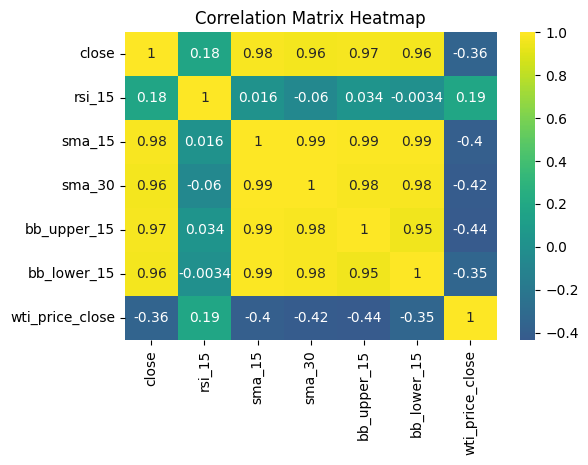

In [52]:
# Corr heatmap

df_cor = ppl.df.copy()

norm_columns = ['close','rsi_15','sma_15','sma_30','bb_upper_15','bb_lower_15','wti_price_close']
df_cor = src.utils.data_utils.normalize_to_first_value(df_cor,norm_columns)
 

# Compute correlation matrix
corr_matrix = df_cor[norm_columns].dropna().corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', center=0)
plt.title("Correlation Matrix Heatmap")
plt.show()
